# Regression Practice #

The notebook is for practicing implementing linear and logistic regression models. The emphassis is on best implementation practices, so only uses built-in data sets for ease.

In [61]:
# import necessary packages

import pandas as pd
import numpy as np
from sklearn import datasets, model_selection, feature_selection, preprocessing

import sklearn.linear_model as linmodel
import sklearn.metrics as smets

#import statsmodels.api as stmod

import matplotlib.pyplot as plt
import math

## Linear Regression ##

Import built-in diabetes data set from scikit-learn. Data set has 442 samples with 10 features.

In [62]:
data = datasets.load_diabetes()
X = data['data']
Y = data['target']
feature_names = data['feature_names']

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, train_size=0.7)

Create a linear regression model using all features. 
Print model information including coefficients, intercept, and R^2 value.
Evaluate using mean squared error on the test set.

In [63]:
model = linmodel.LinearRegression().fit(X_train, Y_train)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
rsq = model.score(X_train, Y_train)
print('R-squared:', rsq)
print()

Y_pred = model.predict(X_test)
mse = smets.mean_squared_error(Y_test, Y_pred)
print('Mean squared error:', mse)

Coefficients: [ -20.0224976  -274.79403458  528.75341135  324.90078073 -715.51780411
  445.17681063   61.74011666  158.69137652  760.34448146   64.45018143]
Intercept: 153.1619206940207
R-squared: 0.5371118702495459

Mean squared error: 2958.7440006294887


Implement feature selection using SelectKBest() with f_regression() functions to identify the value of each feature. Graph the results to visual which features are useful.

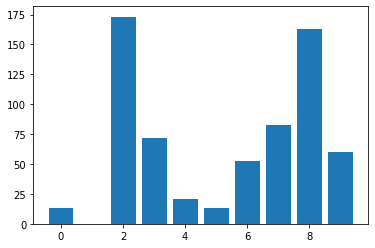

In [64]:
# used to test the output of SelectKBest
#f_st,p_val = feature_selection.f_regression(X_train, Y_train)
#print(f_st)
#print()
#print(p_val)

fit_model = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k='all')
fit_model.fit(X_train, Y_train)
scores = fit_model.scores_

x_ind = np.arange(len(scores))
plt.bar(x_ind, scores)
plt.show()

Based on results, it looks like the best feature is 2, while 8 is also useful. It seems like there are several other useful features, though 1, 5, and 4 are least useful. 

As an arbitrary choice, I will assume adding features 2, 3, 6, 7, 8, 9 as possibly useful for model construction and worthwhile exploring. The number of features that should be used can be viewed as a hyperparameter which can be searched over. 

I will test constructing a model with features, in order of importance by f-statistic and find which offers the best performance on the training data as measured by mean-squared error. When adding a feature to the model, I will continue including the strategies that were deemed more important than it.

In [65]:
# running with subsets of the data will probably be easiest by turning data into dataframe
X_train_df = pd.DataFrame(X_train)

features = [2, 8, 7, 3, 9, 6]
best_sub = [] # best subset of features seen
best_mse = math.inf # best mean_squared error seen

for fi in range(1, len(features)):
    # gather data for features
    curr_feat = features[:fi]
    sub_X = X_train_df[curr_feat]
    if len(curr_feat) == 1:
        sub_X = sub_X.to_numpy().reshape((-1, 1))
        
    # create model and test mse
    sub_model = linmodel.LinearRegression().fit(sub_X, Y_train)
    Y_pred = sub_model.predict(sub_X)
    
    mse = smets.mean_squared_error(Y_train, Y_pred)
    if mse < best_mse:
        best_mse = mse
        best_sub = curr_feat    

print('Best features:', best_sub)

Best features: [2, 8, 7, 3, 9]


Results show that a model with features 2, 3, 7, 8, and 9 demonstrate the best performance on the training data. This also shows my arbitrary choice of cut off point for which features to test was ok, since the wort feature was not deemed useful for the model.

Next, I will construct a model using those features and compare results to the model with all features included when predicting the test set. Note, I could have just used output from the above feature search, but I wanted to separate out the different steps for demonstration purposes.

In [6]:
# make data sets use only necessary features
feats = [2, 3, 7, 8, 9]
new_X_train = X_train_df[feats]
new_X_test = pd.DataFrame(X_test)
new_X_test = new_X_test[feats]

model = linmodel.LinearRegression().fit(new_X_train, Y_train)
rsq = model.score(new_X_train, Y_train)
print('R-squared:', rsq)

Y_pred = model.predict(new_X_test)
mse = smets.mean_squared_error(Y_test, Y_pred)
print('Mean-squared error:', mse)

R-squared: 0.4826258865786448
Mean-squared error: 3278.2439983415134


### Observations ###

Model with all features:
R^2: 0.523
MSE: 3126.589

Model with selective features:
R^2: 0.483
MSE: 3278.244

Data shows that with feature selection, model performance on the test set actually degrades slightly (lower R^2 and a higher MSE). It may be that the feature selected model is overfitting slightly. This data set is rather small (train set has ~309 and testing 


#### Second example using the California Housing data set. ####

---------------------------
All features:
--R-squared: 0.6061736167815731
--MSE: 0.5191254571317265
---------------------------


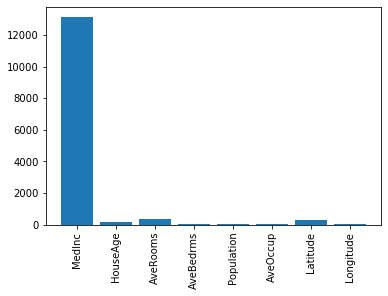

---------------------------
All features:
--R-squared: 0.4761897524966152
--MSE: 0.701149848292339
---------------------------


In [27]:
# test the above using a different data set
data = datasets.fetch_california_housing(as_frame=True)
fnames = data['feature_names']
X = data['data']
Y = data['target']

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, train_size=0.7)

# construct model with all data
model = linmodel.LinearRegression().fit(X_train, Y_train)
rsq = model.score(X_train, Y_train)
Y_pred = model.predict(X_test)
mse = smets.mean_squared_error(Y_test, Y_pred)
print('---------------------------')
print('All features:')
print('--R-squared:', rsq)
print('--MSE:', mse)
print('---------------------------')

# perform feature selection
fmodel = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k='all')
fmodel.fit(X_train, Y_train)
scores = fmodel.scores_

plt.bar(fnames, scores)
plt.xticks(rotation=90)
plt.show()

# create model using top features
new_X_train = X_train[['MedInc']]
new_X_test = X_test[['MedInc']]

model = linmodel.LinearRegression().fit(new_X_train, Y_train)
rsq = model.score(new_X_train, Y_train)
Y_pred = model.predict(new_X_test)
mse = smets.mean_squared_error(Y_test, Y_pred)
print('---------------------------')
print('All features:')
print('--R-squared:', rsq)
print('--MSE:', mse)
print('---------------------------')

Similarly finding that feature selection is showing slightly degraded performance. Think in both cases, while there's not as much information coming from the other features, they are still signaling something of use for the model.

## Logistic Regression ##

Import scikit-learn built-in cancer data set, which has 2 classes (Malignant: 212 samples, Benign: 357 samples). There are 30 features.

In [43]:
data = datasets.load_breast_cancer()
X = data['data']
Y = data['target']
fnames = data['feature_names']
print('Features:', fnames)

# apply normalization to fix logistic regression over stopping iterations
X = preprocessing.Normalizer().fit_transform(X, Y)

X_train,X_test,Y_train,Y_test = model_selection.train_test_split(X, Y, train_size=0.7)

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


Create a logistic regression model using all the features.

In [44]:
model = linmodel.LogisticRegression(max_iter=100).fit(X_train, Y_train)
#Y_pred = model.predict(X_test)
acc = model.score(X_test, Y_test)
print('Accuracy:', acc)

Accuracy: 0.7426900584795322
